In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Load bostod housing dataset

In [13]:
from sklearn.datasets import load_boston
print(load_boston()['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [14]:
dataset = pd.DataFrame(data=load_boston()['data'], columns=load_boston()['feature_names'])
X = dataset.values
y = load_boston()['target']

In [15]:
dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [16]:
feature_type_mapping = {
    'CRIM': 'continuous',
    'ZN': 'continuous',
    'INDUS': 'continuous',
    'CHAS': 'discrete',
    'NOX': 'continuous',
    'RM': 'continuous',
    'AGE': 'continuous',
    'DIS': 'continuous',
    'RAD': 'discrete',
    'TAX': 'continuous',
    'PTRATIO': 'continuous',
    'B': 'continuous',
    'LSTAT': 'continuous'
}

Create regression model

In [17]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=10)
model.fit(X, y)

/home/waldemar/.virtualenvs/besmart_1.0/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# PDP plots

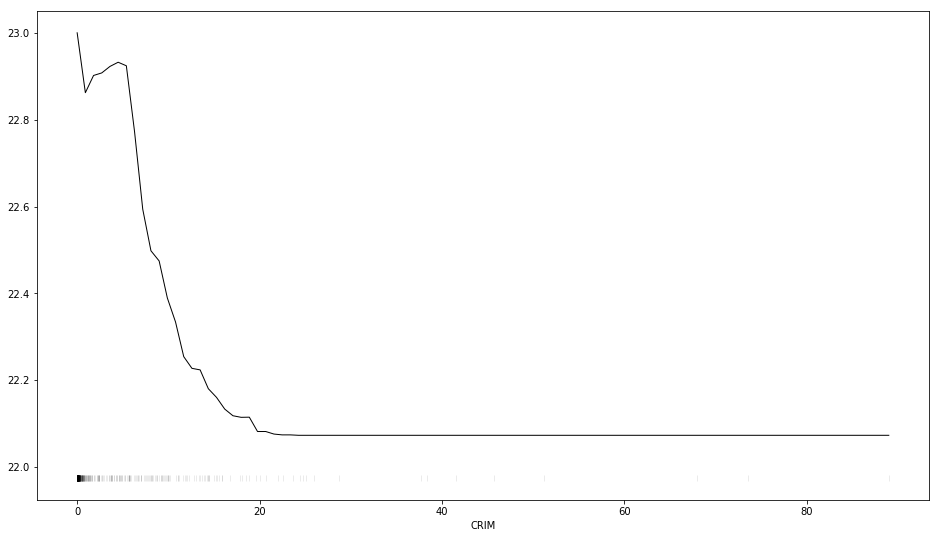

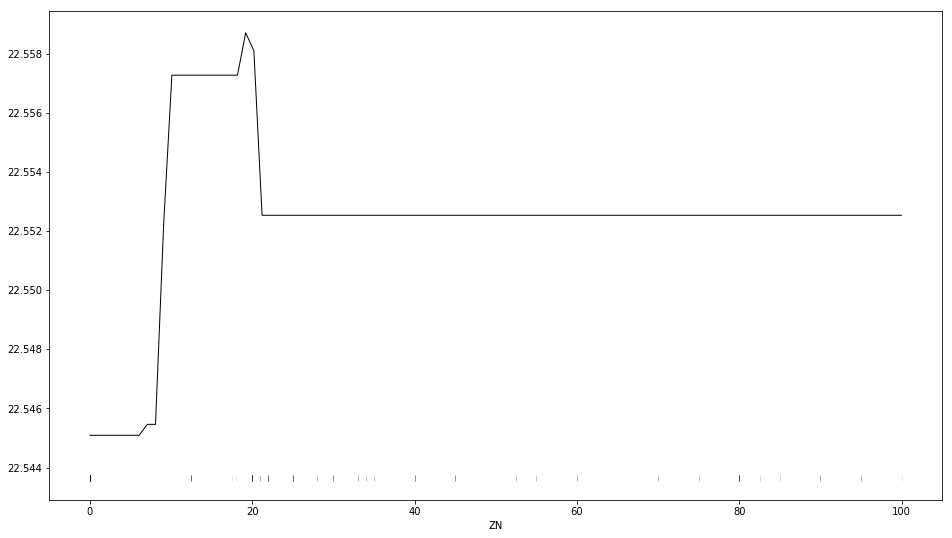

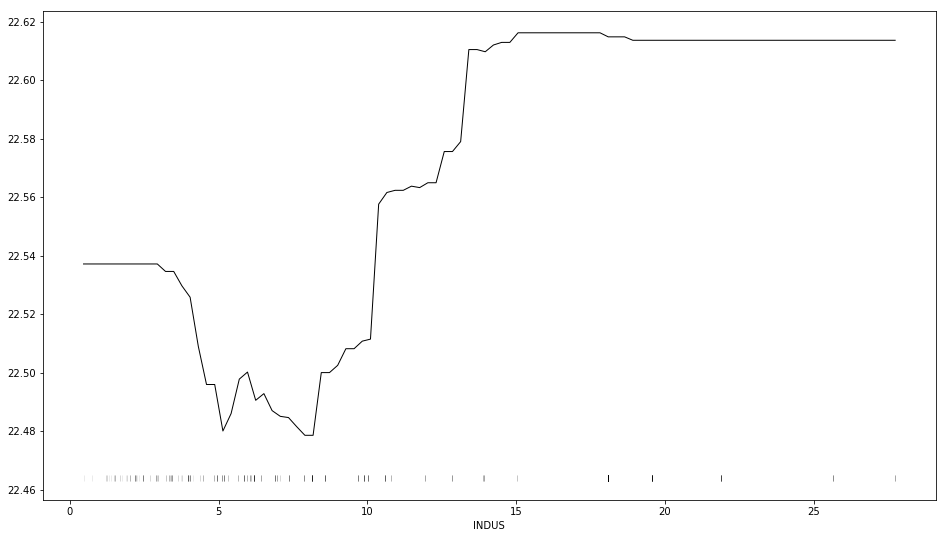

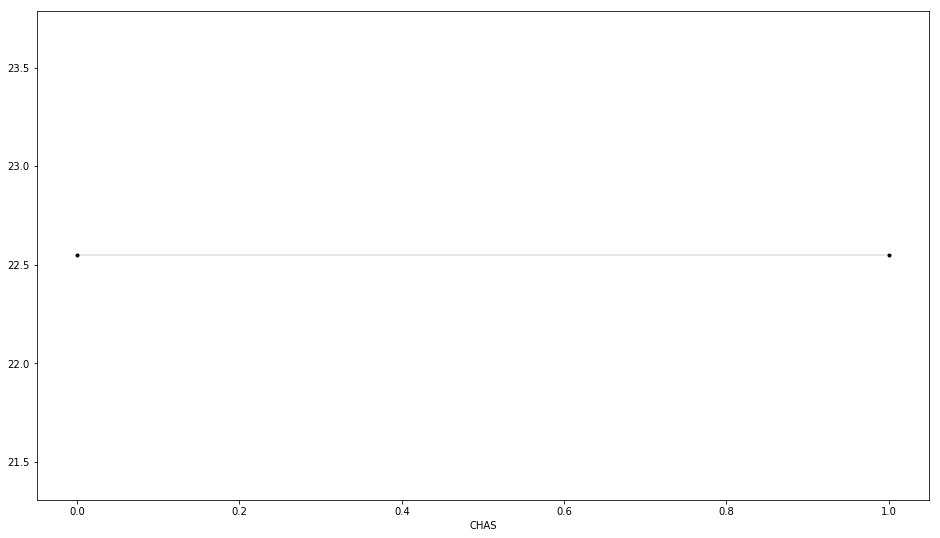

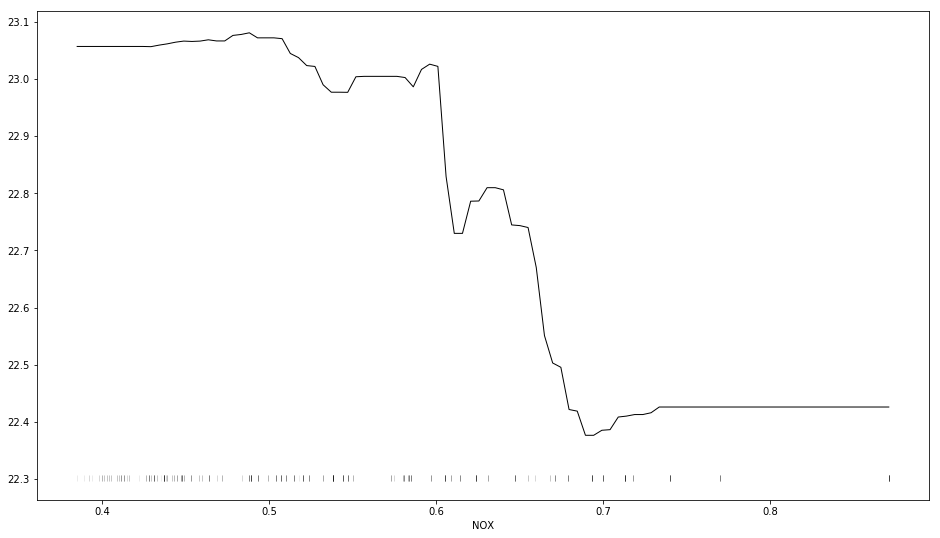

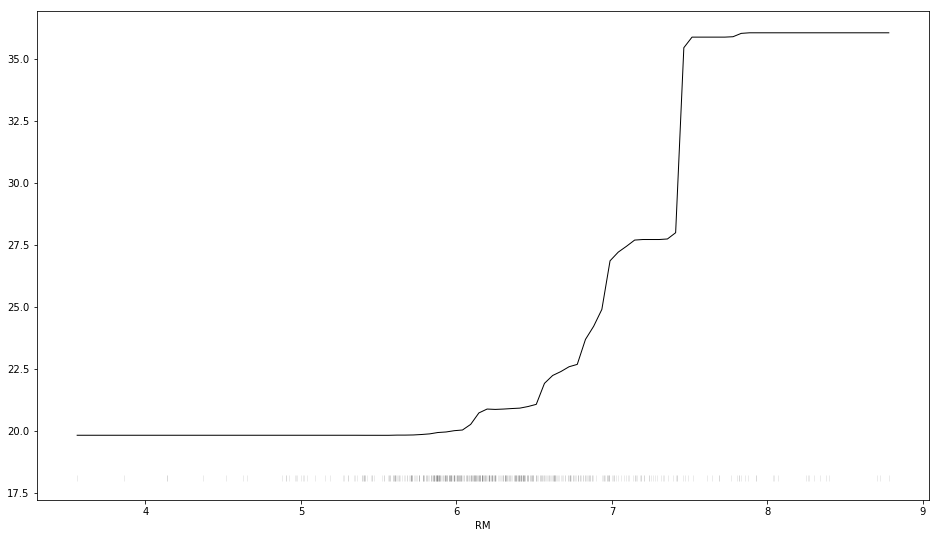

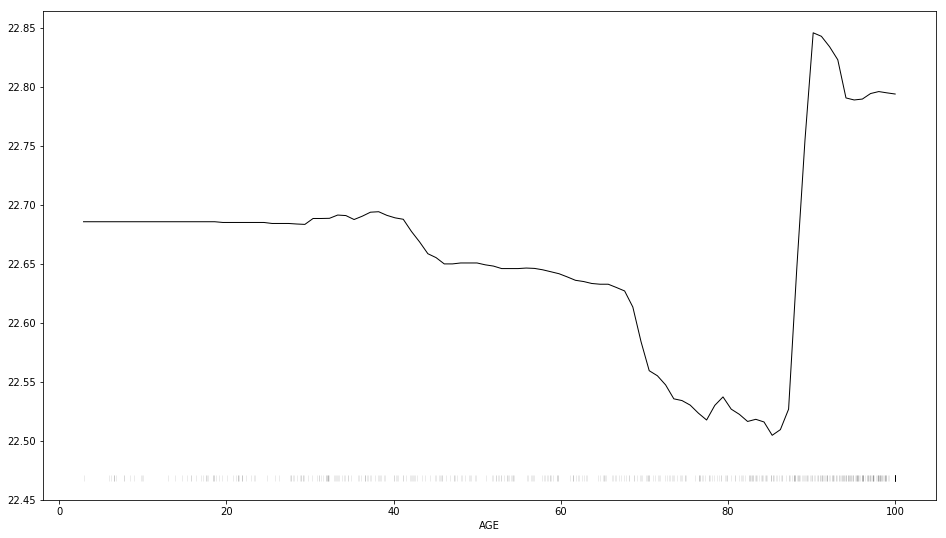

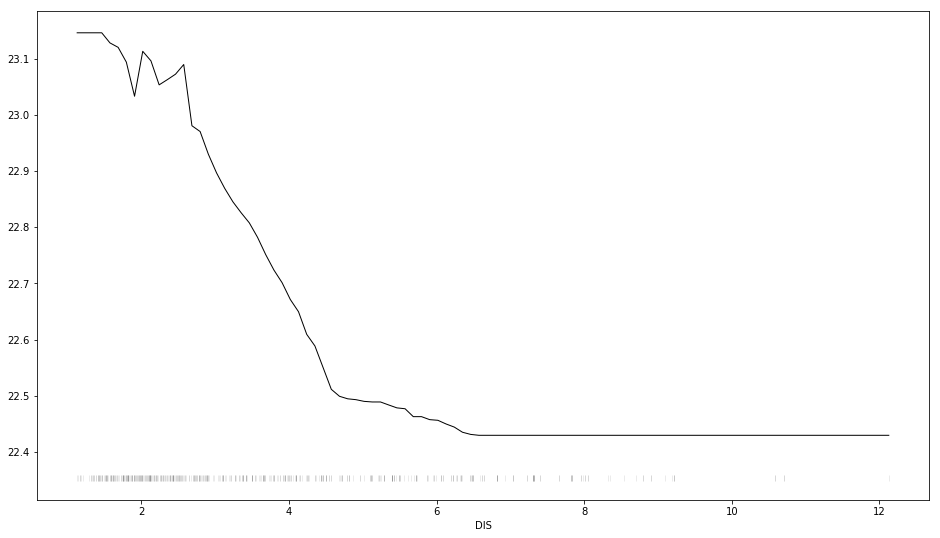

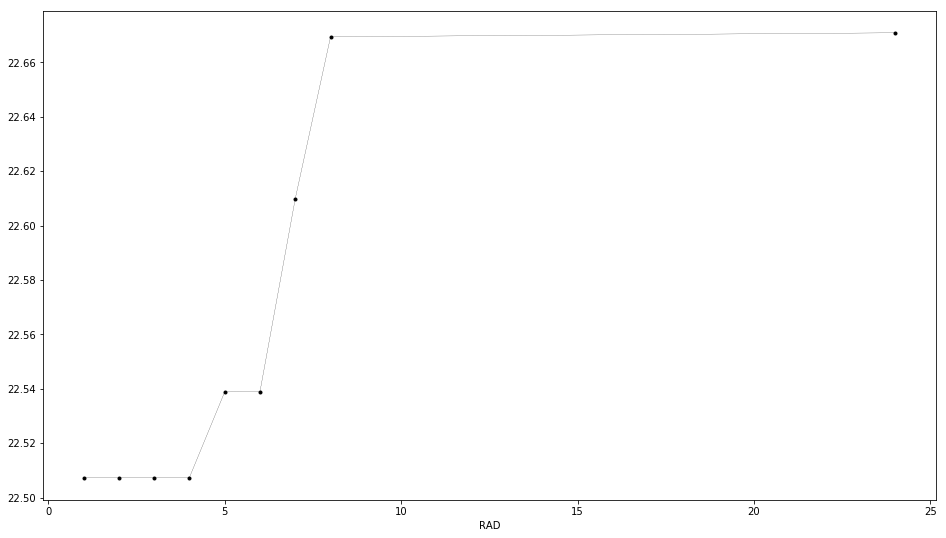

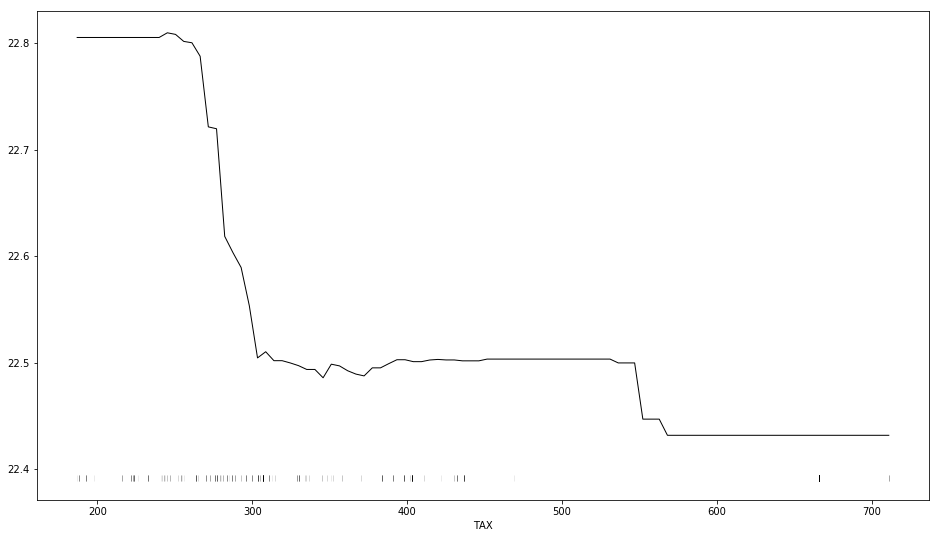

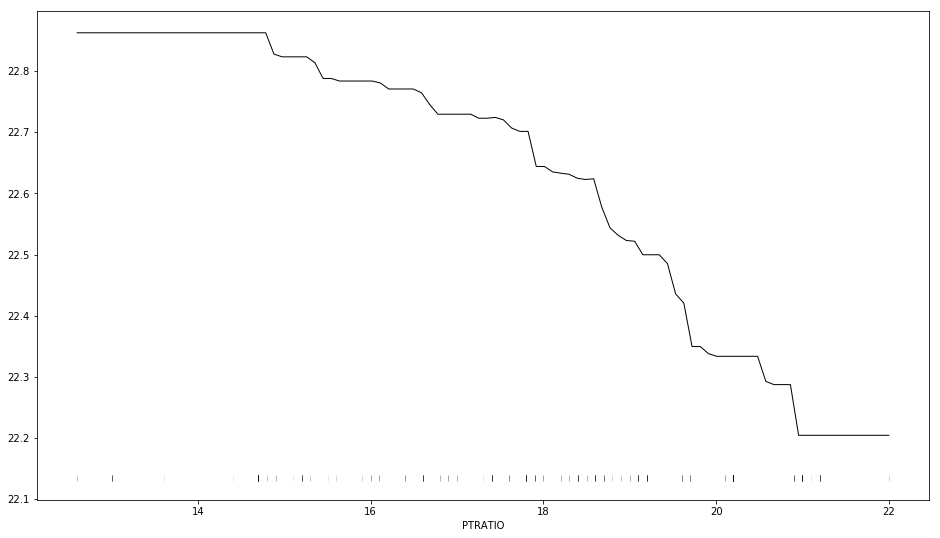

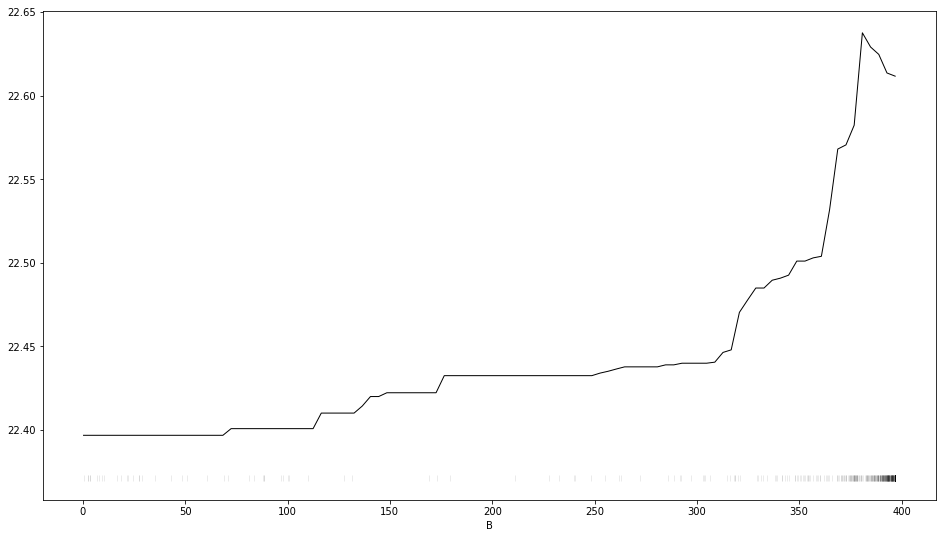

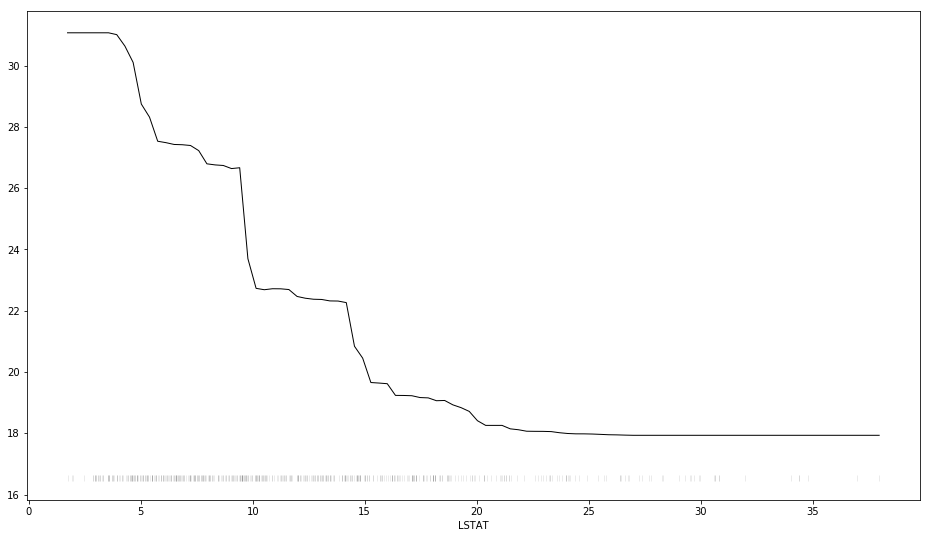

In [7]:
from partial_dependence_plot import plot_pdp

for f, feature_name in enumerate(dataset.columns):
    
#     feature_type = 'continuous'
    feature_type = feature_type_mapping[feature_name]
    pdp_df = plot_pdp(model=model,
                      features=X, 
                      feature_number=f, 
                      feature_name=feature_name, 
                      feature_type=feature_type)

    if feature_type == 'discrete':
        pdp_df.plot(figsize=(16, 9), 
                    legend=False, 
                    marker='o', 
                    linewidth=0.2, 
                    markersize=3, 
                    color='black')
        
    elif feature_type == 'continuous':
        pdp_df.plot(figsize=(16, 9), 
                    legend=False, 
                    linewidth=1, 
                    color='black')
        ax = plt.gca()
        bottom, top = ax.get_ylim()
        indicator_height = 0.05 * (top - bottom)
        ax.plot(dataset[feature_name].values, 
                [bottom - indicator_height]*dataset.shape[0], 
                '|', 
                color='k', 
                alpha=0.08)

# ICE plots

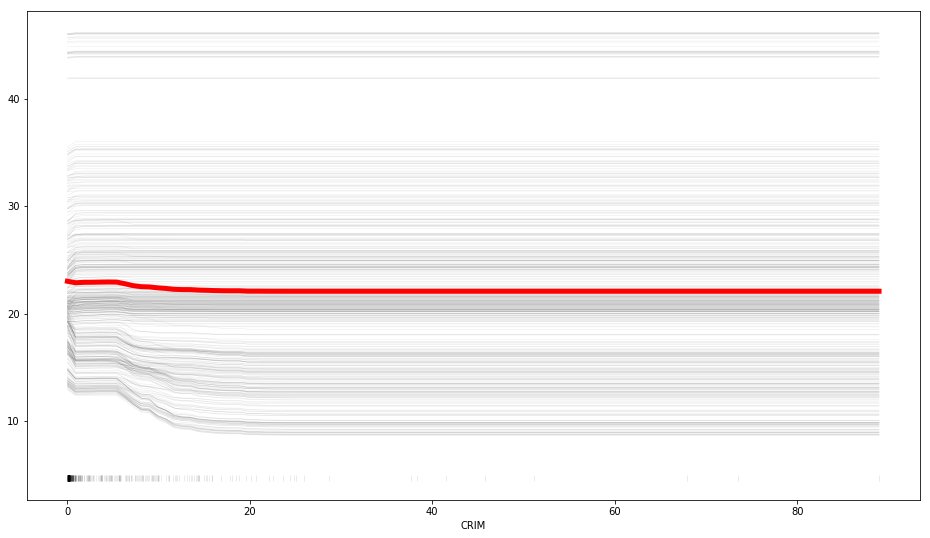

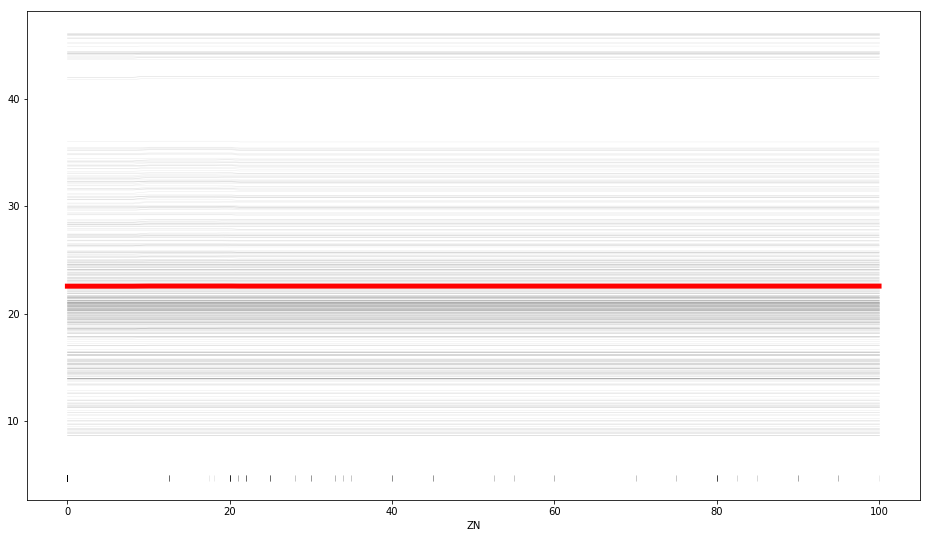

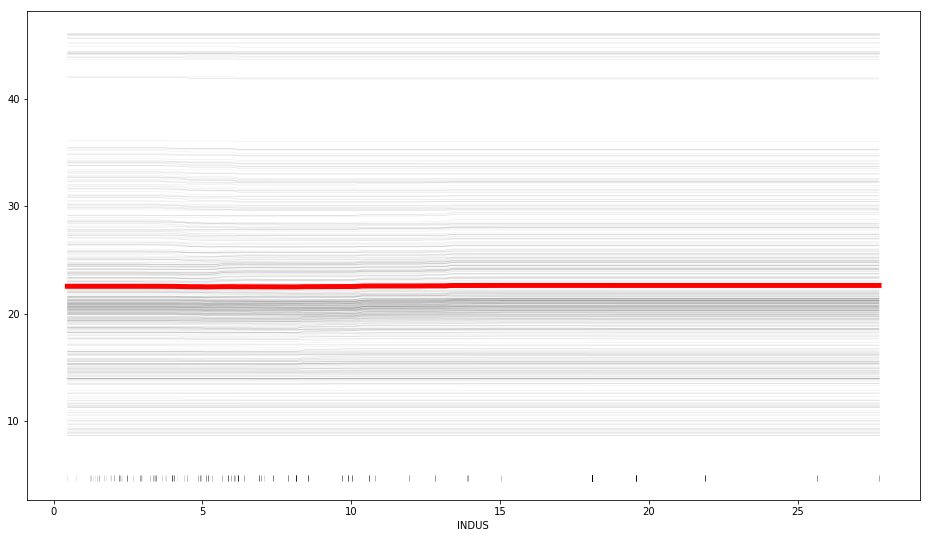

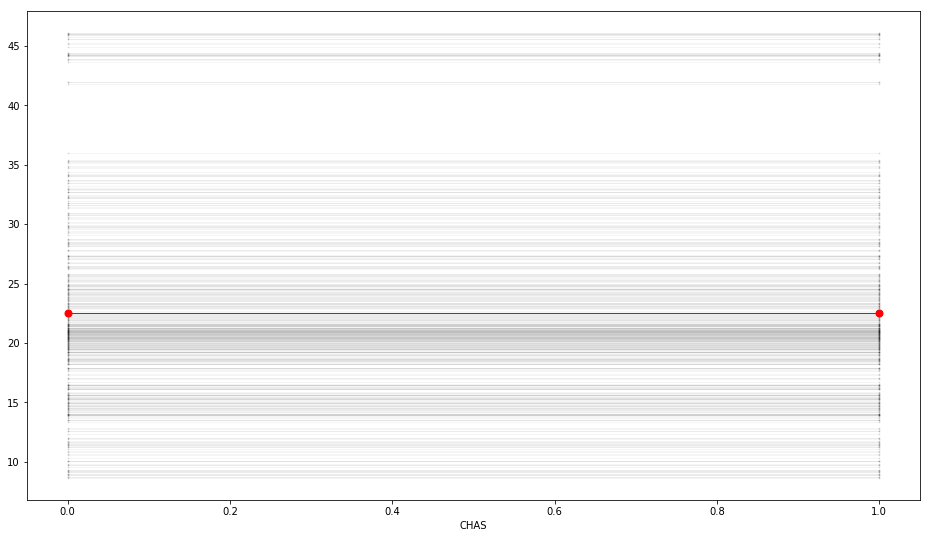

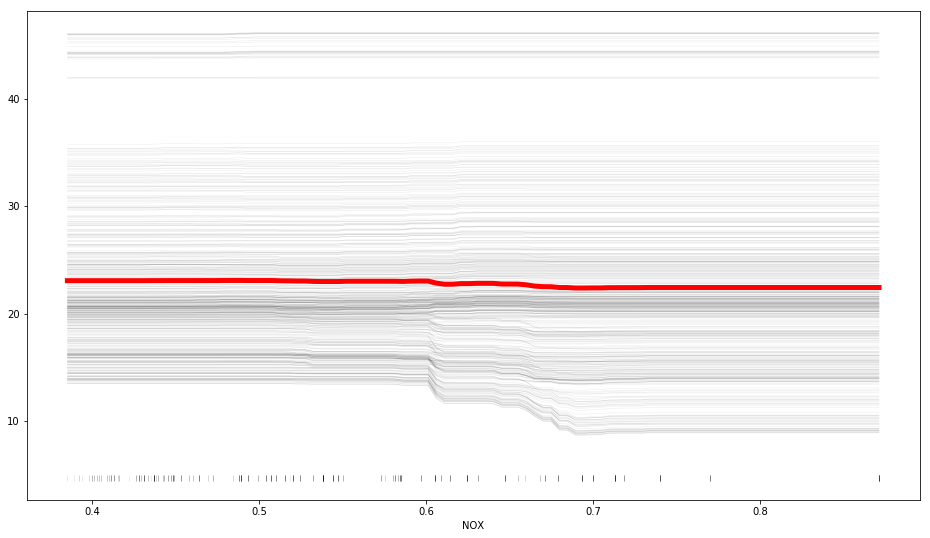

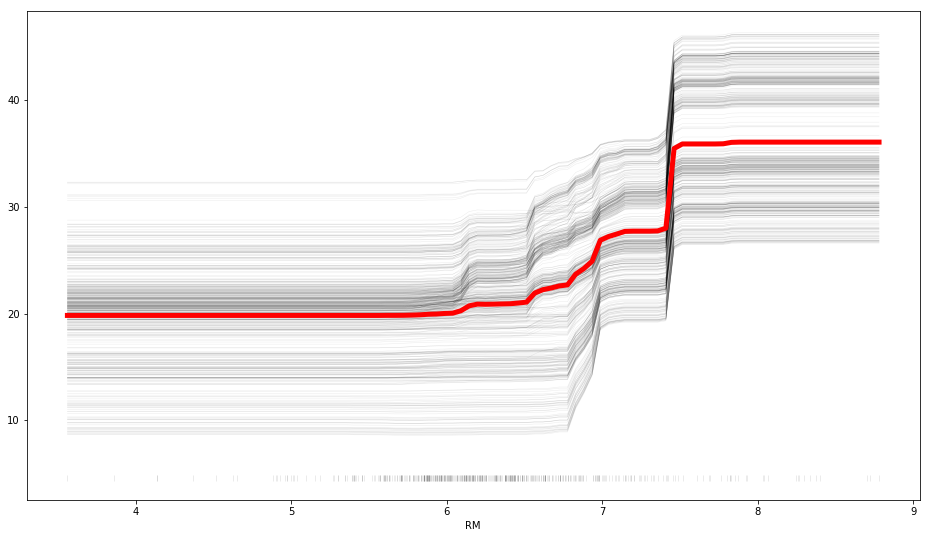

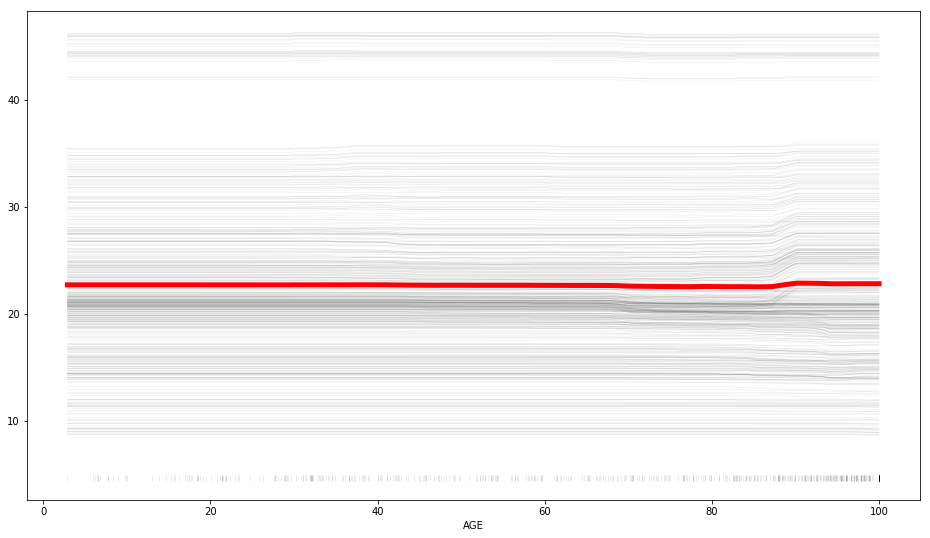

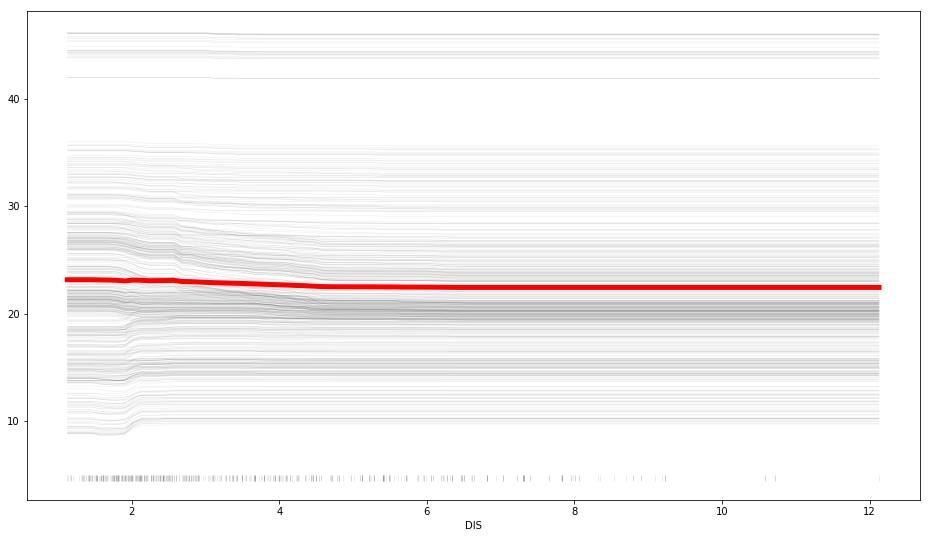

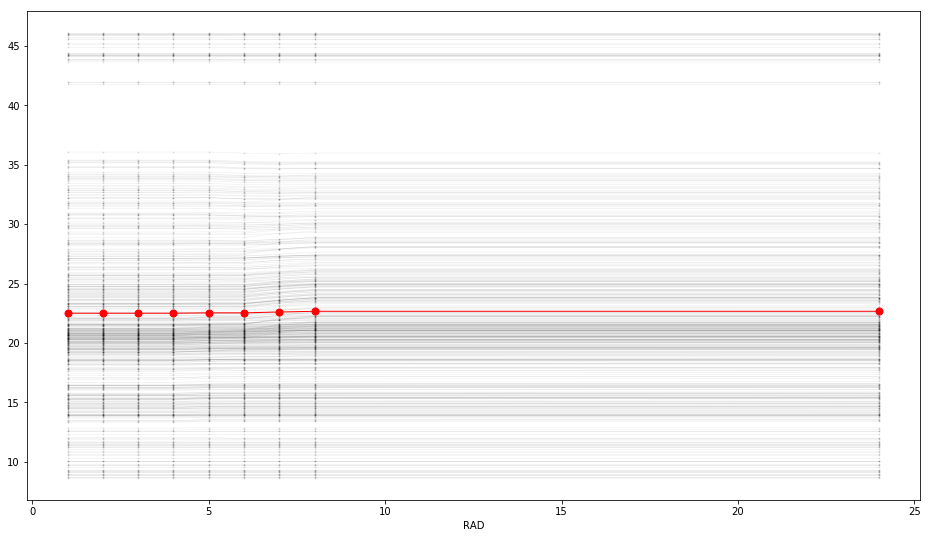

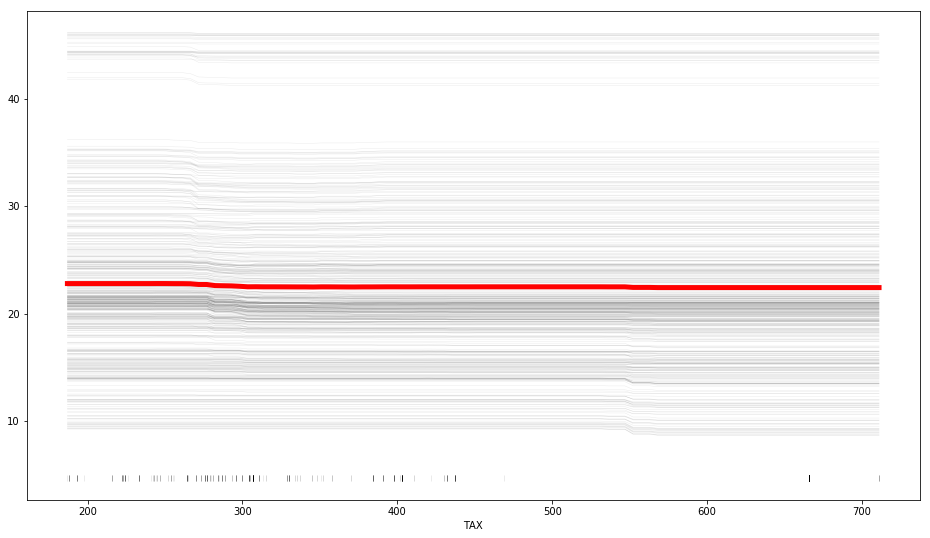

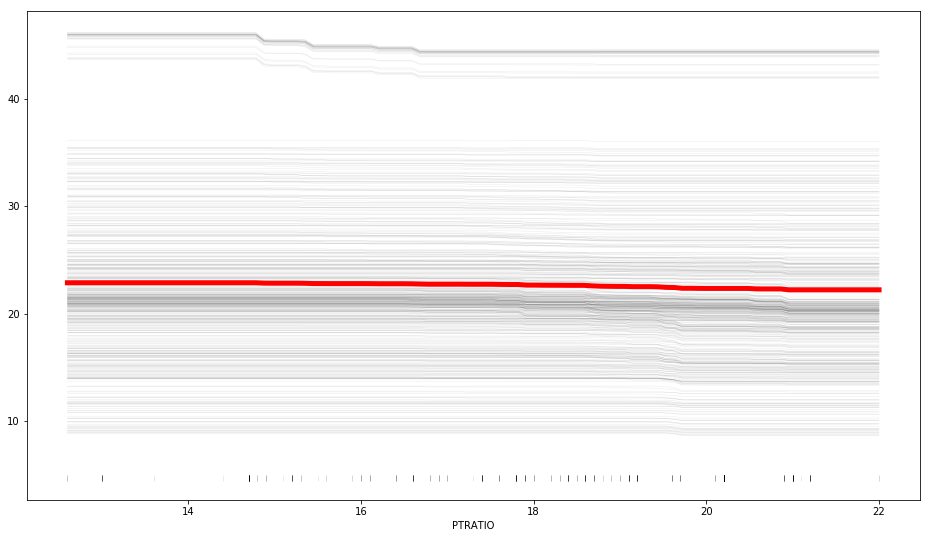

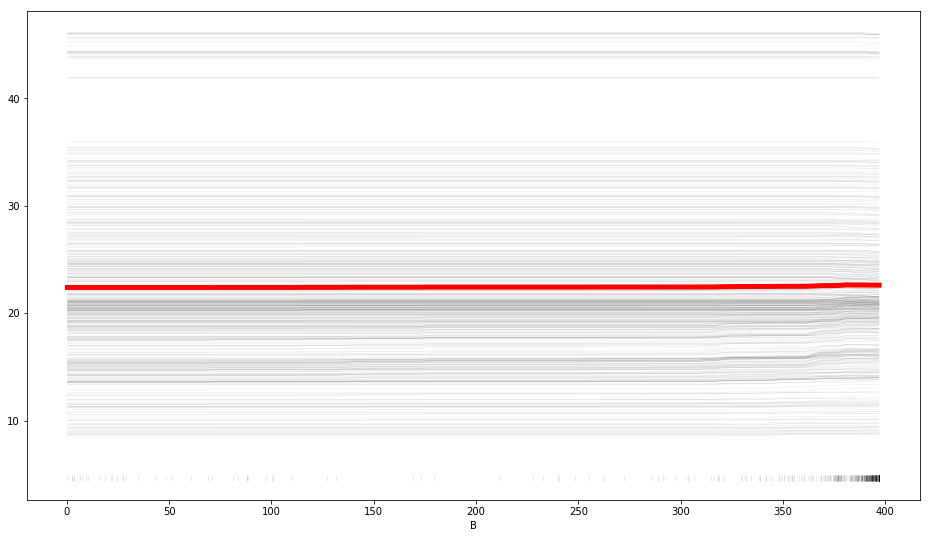

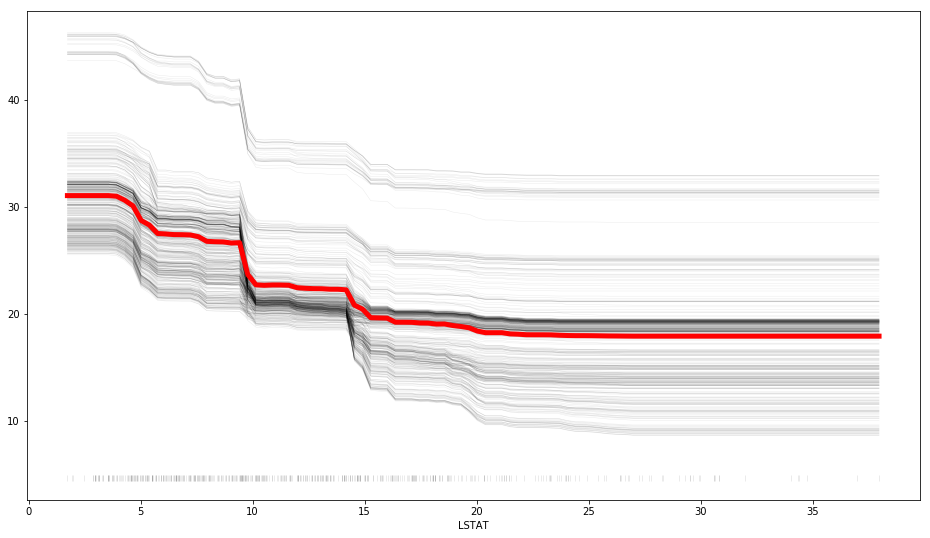

In [8]:
from partial_dependence_plot import plot_ice

for f, feature_name in enumerate(dataset.columns):
    
    feature_type = feature_type_mapping[feature_name]
    ice_df = plot_ice(model=model,
                      features=X, 
                      feature_number=f, 
                      feature_name=feature_name, 
                      feature_type=feature_type)
    
    if feature_type == 'discrete':
        ax = ice_df.plot(figsize=(16, 9), 
                         legend=False, 
                         marker='o', 
                         linewidth=0.5, 
                         markersize=1, 
                         color='black', 
                         alpha=0.08)
        ice_df.mean(axis=1).plot(c='red', 
                                 linewidth=1, 
                                 legend=False, 
                                 ax=ax, 
                                 marker='o', 
                                 markersize=7)
        
    elif feature_type == 'continuous':
        ax = ice_df.plot(figsize=(16, 9), 
                         c='k', 
                         alpha=0.08, 
                         legend=False, 
                         linewidth=0.5)
        ice_df.mean(axis=1).plot(c='red', 
                                 linewidth=5, 
                                 legend=False, 
                                 ax=ax)

        bottom, top = ax.get_ylim()
        indicator_height = 0.05 * (top - bottom)
        ax.plot(dataset[feature_name].values, 
                [bottom - indicator_height] * dataset.shape[0], 
                '|', 
                color='k',
                alpha=0.08)

# Permutation importance

In [18]:
def mean_absolute_error(y_test, y_pred):
    return np.mean(np.abs(y_test - y_pred))

In [35]:
from permutation_importance import permutation_importance_one_feature

err = permutation_importance_one_feature(model=model,
                                   X=X, 
                                   y=y,
                                   feature_number=5,
                                   error_func=mean_absolute_error)

[========================================================================] 100%


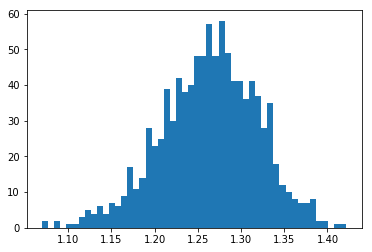

In [11]:
ax = plt.hist(err, bins=50)

In [36]:
from permutation_importance import permutation_importance

ref_df = permutation_importance(model=model,
                                X=X, 
                                y=y,
                                feature_names=dataset.columns,
                                error_func=mean_absolute_error)
ref_df = ref_df.reindex(ref_df.mean().sort_values(ascending=True).index, axis=1)

Processing feature 0


[========================================================================] 100%


Processing feature 1


[========================================================================] 100%


Processing feature 2


[========================================================================] 100%


Processing feature 3


[========================================================================] 100%


Processing feature 4


[========================================================================] 100%


Processing feature 5


[========================================================================] 100%


Processing feature 6


[========================================================================] 100%


Processing feature 7


[========================================================================] 100%


Processing feature 8


[========================================================================] 100%


Processing feature 9


[========================================================================] 100%


Processing feature 10


[========================================================================] 100%


Processing feature 11


KeyboardInterrupt: 

In [13]:
ref_df

,CHAS,ZN,RAD,INDUS,B,TAX,PTRATIO,AGE,DIS,NOX,CRIM,RM,LSTAT
0,0.0,0.002072,0.013584,0.021048,0.025904,0.035296,0.058883,0.056910,0.122085,0.167688,0.144578,1.239141,1.893755
1,0.0,0.001834,0.012287,0.014749,0.019442,0.033454,0.067292,0.061770,0.104543,0.161172,0.154815,1.346935,1.851006
2,0.0,0.002469,0.013416,0.021481,0.019446,0.028297,0.056208,0.065634,0.109826,0.145920,0.156019,1.270152,1.924790
3,0.0,0.001612,0.011833,0.016735,0.022179,0.035050,0.057055,0.057687,0.111688,0.147105,0.145866,1.255397,2.034537
4,0.0,0.001713,0.012713,0.023086,0.021844,0.026872,0.044598,0.037025,0.107938,0.149121,0.142459,1.283644,1.879699
5,0.0,0.001951,0.006557,0.015870,0.021740,0.027523,0.057771,0.058336,0.117078,0.124741,0.153465,1.283934,1.873470
6,0.0,0.001209,0.007781,0.020450,0.022229,0.032511,0.056944,0.061259,0.112554,0.143199,0.157752,1.235648,1.932329
7,0.0,0.000964,0.013709,0.018822,0.022831,0.025350,0.058341,0.060637,0.121372,0.142015,0.162952,1.223032,1.859423
8,0.0,0.001648,0.012497,0.021619,0.024206,0.028682,0.054009,0.054125,0.128556,0.160476,0.171200,1.254885,1.826929
9,0.0,0.000938,0.012436,0.021355,0.023974,0.029801,0.054296,0.063451,0.105983,0.156556,0.176060,1.317505,2.016297


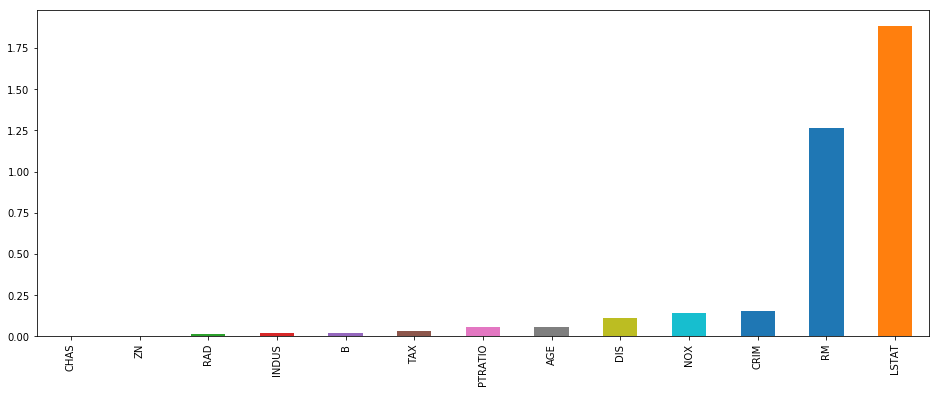

In [14]:
ref_df.mean().plot.bar(figsize=(16, 6))

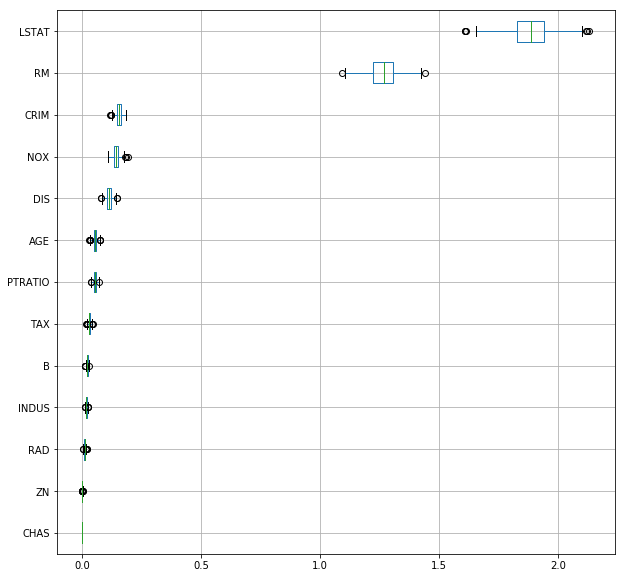

In [15]:
ref_df.boxplot(vert=False, figsize=(10, 10))

In [37]:
!pip3 install progressbar2

You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [38]:
!pip3 freeze 

absl-py==0.2.2
astor==0.6.2
attrs==19.3.0
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chardet==3.0.4
cycler==0.10.0
Cython==0.29.7
decorator==4.3.0
defusedxml==0.6.0
entrypoints==0.3
findspark==1.3.0
future==0.17.1
gast==0.2.0
grpcio==1.13.0
gym==0.12.1
h5py==2.8.0
html5lib==0.9999999
idna==2.6
importlib-metadata==1.2.0
influxdb==5.0.0
ipykernel==4.8.2
ipython==6.4.0
ipython-genutils==0.2.0
jedi==0.12.0
Jinja2==2.10.1
joblib==0.14.1
json-tricks==3.13.5
jsonschema==3.2.0
jupyter-client==5.3.4
jupyter-core==4.6.1
Keras==2.2.0
Keras-Applications==1.0.2
Keras-Preprocessing==1.0.1
kiwisolver==1.1.0
Markdown==2.6.11
MarkupSafe==1.1.1
matplotlib==3.0.3
mistune==0.8.4
mock==3.0.5
more-itertools==8.0.2
nbconvert==5.6.1
nbformat==4.4.0
nltk==3.4.1
notebook==6.0.2
numpy==1.17.4
packaging==19.2
pandas==0.23.0
pandocfilters==1.4.2
parso==0.2.1
pathlib2==2.3.5
patsy==0.5.0
pbr==5.1.1
pexpect==4.6.0
pickleshare==0.7.4
Pillow==5.4.1
pluggy==0.13.1
progressbar==2.5
progressbar2==3.47.0
prometheus-